# Extract RGB from PAD Columns

<font color='red'>Warning!</font> This notebook is a work in progress.

This notebook describes the process of extracting RGB colors from a PAD.

Upper case variables are for user inputs. Change these. Lower case variables usually can be left alone.

## Contents

- [Imports](#Imports)
- [Load Image](#Load-Image)
- [Optionally Invert Colors](#Optionally-Invert-Colors)
- [Rotate Image](#Rotate-Image)
- [Detect Columns](#Detect-Columns)
- [Draw Columns as Overlay on Image](#Draw-Columns-as-Overlay-on-Image)
- [Pull Pixels from Each Column](#Pull-Pixels-from-Each-Column)

## Imports

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pathlib
from datetime import datetime

In [2]:
%matplotlib inline

### Load Images

Change this to the directory with your images.

In [3]:
INPUT_DIRECTORY = "raw_images"
OUTPUT_DIRECTORY = "output_20190317"
OUTPUT_PER_COLUMN_CSV = "columns_20190317.csv"
OUTPUT_PER_FILE_CSV = "summary_20190317.csv"

In [4]:
if not os.path.isdir(OUTPUT_DIRECTORY):
    os.mkdir(OUTPUT_DIRECTORY)
    print("Created: {}".format(OUTPUT_DIRECTORY))
print("Already exists: {}".format(OUTPUT_DIRECTORY))
output_per_column_csv_path = pathlib.Path(os.path.join(os.getcwd(), OUTPUT_DIRECTORY, OUTPUT_PER_COLUMN_CSV))
print("Column output CSV: {}".format(str(output_per_column_csv_path)))
output_per_file_csv_path = pathlib.Path(os.path.join(os.getcwd(), OUTPUT_DIRECTORY, OUTPUT_PER_FILE_CSV))
print("Summary output CSV: {}".format(str(output_per_file_csv_path)))

Already exists: output_20190317
Column output CSV: C:\Users\ericc\projects\colors\output_20190317\columns_20190317.csv
Summary output CSV: C:\Users\ericc\projects\colors\output_20190317\summary_20190317.csv


Let this take care of the rest.

In [5]:
image_filenames = [pathlib.Path(os.path.join(os.getcwd(), INPUT_DIRECTORY, x)) for x in os.listdir(INPUT_DIRECTORY) if x.endswith('.jpg')]
print("Found these files:\n{}".format("\n".join([str(x) for x in image_filenames])))

Found these files:
C:\Users\ericc\projects\colors\raw_images\IMG_20190313_160509.jpg
C:\Users\ericc\projects\colors\raw_images\IMG_20190313_160532.jpg
C:\Users\ericc\projects\colors\raw_images\IMG_20190313_160600.jpg
C:\Users\ericc\projects\colors\raw_images\IMG_20190313_160630.jpg
C:\Users\ericc\projects\colors\raw_images\IMG_20190313_160700.jpg
C:\Users\ericc\projects\colors\raw_images\IMG_20190313_160730.jpg
C:\Users\ericc\projects\colors\raw_images\IMG_20190313_160801.jpg
C:\Users\ericc\projects\colors\raw_images\IMG_20190313_160830.jpg
C:\Users\ericc\projects\colors\raw_images\IMG_20190313_160900.jpg
C:\Users\ericc\projects\colors\raw_images\IMG_20190313_160930.jpg
C:\Users\ericc\projects\colors\raw_images\IMG_20190313_161000.jpg
C:\Users\ericc\projects\colors\raw_images\IMG_20190313_161031.jpg
C:\Users\ericc\projects\colors\raw_images\IMG_20190313_161101.jpg
C:\Users\ericc\projects\colors\raw_images\IMG_20190313_161130.jpg
C:\Users\ericc\projects\colors\raw_images\IMG_20190313_16

### Try Manual Box Placement

In [6]:
def sample_boxes(
    pathlib_filename,
    box_width=50,
    box_height=500,
    num_boxes=12,
    offset_top=1250,
    offset_left=560,
    horizontal_spacer=109,
    output_dir="output",
    draw=True,
    verbose=False
):
    column_data = []
    if verbose:
        print("Reading: {}".format(str(pathlib_filename)))
    image = cv2.imread(str(pathlib_filename))
    for x in range(num_boxes):
        # Define rectangle to sample.
        box_top_left_x = int(offset_left + horizontal_spacer * x + box_width * x)
        box_top_left_y = int(offset_top)
        box_bottom_right_x = int(box_top_left_x + box_width)
        box_bottom_right_y = int(offset_top + box_height)
        
        # Sample colors.
        pixels_in_box = image[box_top_left_y:box_bottom_right_y, box_top_left_x:box_bottom_right_x]
        average_color = pixels_in_box.mean(axis=0).mean(axis=0)

        # Not used, but this will save the cropped pixels used for sampling.
        # Would be cool to embed this into an output Excel.
        # cv2.imwrite("test.jpg", pixels_in_box)
        
        # Work out the date and time.
        _, date_string, time_string = pathlib_filename.stem.split('_')
        file_creation_date = datetime.strptime(date_string, "%Y%m%d")
        file_creation_time = datetime.strptime(time_string, "%H%M%S")
        file_creation_datetime = datetime.strptime(date_string + time_string, "%Y%m%d%H%M%S")
        
        # Save data from box.
        datum = {
            "Filename": str(pathlib_filename),
            "Column": x,
            "TopLeftX": box_top_left_x,
            "TopLeftY": box_top_left_y,
            "BottomRightX": box_bottom_right_x,
            "BottomRightY": box_bottom_right_y,
            "AverageBlue": average_color[0],
            "AverageGreen": average_color[1],
            "AverageRed": average_color[2],
            "Date": file_creation_date,
            "Time": file_creation_time,
            "Datetime": file_creation_datetime
        }
        column_data.append(datum)
        
        # If you want to draw.
        if draw:
            cv2.rectangle(
                image,
                (box_top_left_x, box_top_left_y),
                (box_bottom_right_x, box_bottom_right_y),
                (255, 0, 0),
                21
            )

    blue_described = pd.Series([x["AverageBlue"] for x in column_data]).describe()
    green_described = pd.Series([x["AverageGreen"] for x in column_data]).describe()
    red_described = pd.Series([x["AverageRed"] for x in column_data]).describe()
    # Average of columns.
    summary_data = {
        "Filename": str(pathlib_filename),
        "BlueMean": blue_described["mean"],
        "BlueStd": blue_described["std"],
        "BlueMin": blue_described["min"],
        "Blue25%": blue_described["25%"],
        "Blue50%": blue_described["50%"],
        "Blue75%": blue_described["75%"],
        "BlueMax": blue_described["max"],
        "GreenMean": green_described["mean"],
        "GreenStd": green_described["std"],
        "GreenMin": green_described["min"],
        "Green25%": green_described["25%"],
        "Green50%": green_described["50%"],
        "Green75%": green_described["75%"],
        "GreenMax": green_described["max"],
        "RedMean": red_described["mean"],
        "RedStd": red_described["std"],
        "RedMin": red_described["min"],
        "Red25%": red_described["25%"],
        "Red50%": red_described["50%"],
        "Red75%": red_described["75%"],
        "RedMax": red_described["max"],
        "Date": file_creation_date,
        "Time": file_creation_time,
        "Datetime": file_creation_datetime
    }
            
    if draw:
        plt.figure()
        plt.imshow(image)
        output_filename = os.path.join(
            os.getcwd(),
            output_dir,
            pathlib_filename.stem + "_OUTPUT_20190317" + pathlib_filename.suffix
        )
        cv2.imwrite(output_filename, image)
        if verbose:
            print("Wrote: {}".format(output_filename))
    return column_data, summary_data

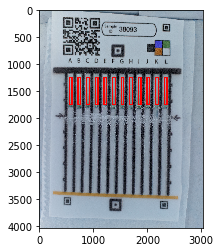

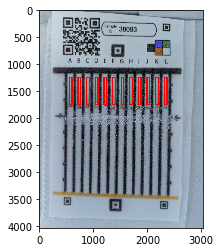

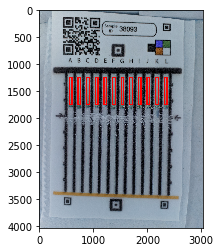

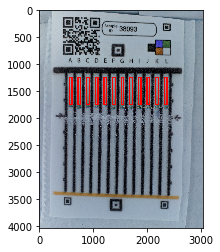

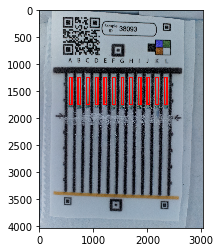

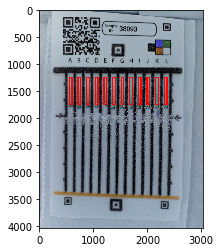

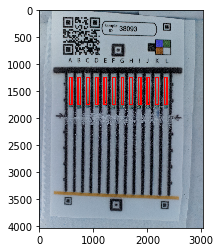

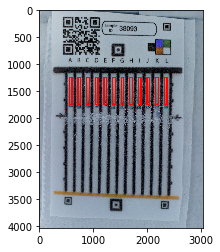

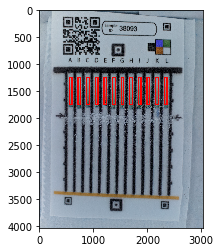

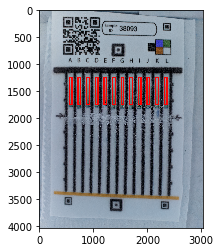

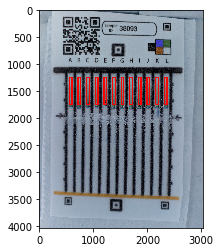

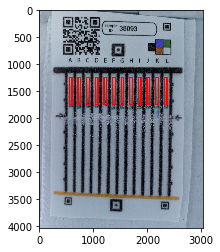

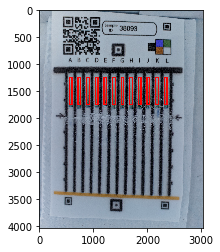

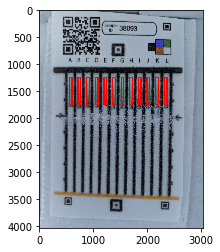

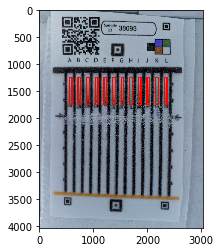

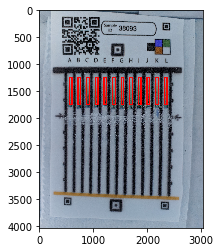

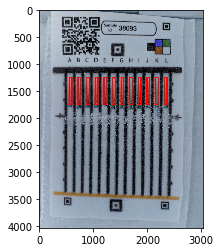

In [7]:
column_data = []
summary_data = []
for image_filename in image_filenames:
    column_data_from_this_file, summary_data_from_this_file = \
        sample_boxes(image_filename, output_dir=OUTPUT_DIRECTORY, verbose=False, draw=True)
    column_data.extend(column_data_from_this_file)
    summary_data.append(summary_data_from_this_file)

In [8]:
column_df = pd.DataFrame(column_data)
column_df["TimeDelta"] = column_df["Time"] - column_df["Time"].min()
column_df["TimeDelta"] = column_df["TimeDelta"].astype('timedelta64[s]')
column_df = column_df[[
    "Filename",
    "Column",
    "TopLeftX",
    "TopLeftY",
    "BottomRightX",
    "BottomRightY",
    "AverageBlue",
    "AverageGreen",
    "AverageRed",
    "Date",
    "Time",
    "Datetime",
    "TimeDelta" 
]]
column_df.to_csv(output_per_column_csv_path)

In [9]:
summary_df = pd.DataFrame(summary_data)
summary_df["TimeDelta"] = summary_df["Time"] - summary_df["Time"].min()
summary_df["TimeDelta"] = summary_df["TimeDelta"].astype('timedelta64[s]')
summary_df = summary_df[[
    "Filename",
    "BlueMean",
    "BlueStd",
    "BlueMin",
    "Blue25%",
    "Blue50%",
    "Blue75%",
    "BlueMax",
    "GreenMean",
    "GreenStd",
    "GreenMin",
    "Green25%",
    "Green50%",
    "Green75%",
    "GreenMax",
    "RedMean",
    "RedStd",
    "RedMin",
    "Red25%",
    "Red50%",
    "Red75%",
    "RedMax",
    "Date",
    "Time",
    "Datetime",
    "TimeDelta"
]]
summary_df.to_csv(output_per_file_csv_path)

### Optionally Invert Colors

### Rotate Image

### Detect Columns

In [10]:
# try_these_1 = [50, 100, 150, 250, 500]
# try_these_2 = [500, 1000, 2000]
# original_image = cv2.imread(filename)
# grayscale_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)
# for x in try_these_1:
#     for y in try_these_2:
#         edges = cv2.Canny(grayscale_image, x, y, apertureSize=5)
#         plt.figure()
#         plt.imshow(edges);
#         plt.title("{} {}".format(x, y))

In [11]:
# try_these_1 = [5, 10, 25, 50, 100, 150]
# try_these_2 = [100, 150, 200, 500, 1000]
# original_image = cv2.imread(filename)
# grayscale_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)
# for x in try_these_1:
#     for y in try_these_2:
#         edges = cv2.Canny(grayscale_image, x, y, apertureSize=5)
#         plt.figure()
#         plt.imshow(edges);
#         plt.title("{} {}".format(x, y))

In [12]:
# filename = "edited_images/test.jpg"
# file_object = cv2.imread(filename)
# grayscale_image = cv2.cvtColor(file_object, cv2.COLOR_BGR2GRAY)
# # plt.imshow(grayscale_image, plt.cm.gray);
# edges = cv2.Canny(grayscale_image, 150, 100, apertureSize=3, L2gradient=True)
# lines = cv2.HoughLines(edges, 1, np.pi/180, 50)
# for line in lines[:50]:
#     rho, theta = line[0]
#     a = np.cos(theta)
#     b = np.sin(theta)
#     x0 = a * rho
#     y0 = b * rho
#     x1 = int(x0 + 1000 * -b)
#     y1 = int(y0 + 1000 * a)
#     x2 = int(x0 - 1000 * -b)
#     y2 = int(x0 - 1000 * a)
#     cv2.line(file_object, (x1, y1), (x2, y2), (0, 0, 255), 5)
# plt.imshow(file_object);

In [13]:
# filename = "edited_images/test.jpg"
# file_object = cv2.imread(filename)
# grayscale_image = cv2.cvtColor(file_object, cv2.COLOR_BGR2GRAY)
# edges = cv2.Canny(grayscale_image, 100, 100, apertureSize=3, L2gradient=True)
# min_line_length = 10
# max_line_gap = 5
# lines = cv2.HoughLinesP(edges, 1, np.pi/180, 100, min_line_length, max_line_gap)
# for line in lines:
#     x1 = line[0][0]
#     y1 = line[0][1]
#     x2 = line[0][2]
#     y2 = line[0][3]
#     cv2.line(file_object, (x1, y1), (x2, y2), (255, 0, 0), 20)
# plt.figure()
# plt.imshow(file_object);
# plt.figure()
# plt.imshow(edges);

### Draw Columns as Overlay on Image

### Pull Pixels from Each Column